In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM

from src.dataset.probe import confidence_function_dataset
# import numpy as np
from src.repe import repe_pipeline_registry
from src.utils import *

repe_pipeline_registry()

C:\Users\17487\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name_or_path = "./Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, torch_dtype=torch.float16, device_map="auto"
)
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False
)
tokenizer.pad_token_id = 0

Loading checkpoint shards: 100%|██████████| 2/2 [00:51<00:00, 25.65s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


In [3]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = "pca"
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [4]:
user_tag = "[INST]"
assistant_tag = "[/INST]"

data_path = (
    "./eval_data/confidence_train.csv"
)
dataset = confidence_function_dataset(
    data_path,
    tokenizer,
    user_tag,
    512,
    assistant_tag,
    pos_tag="a confident",
    neg_tag="an unconfident",
    prompt_type="1",
)

Train data: 1024
Eval data: 512
Test data: 299


In [5]:
# train the probe from scratch
confidence_rep_reader = rep_reading_pipeline.get_directions(
    dataset['train']['data'],
    rep_token=rep_token,
    hidden_layers=hidden_layers,
    n_difference=n_difference,
    train_labels=dataset['train']['labels'],
    direction_method=direction_method,
    batch_size=32,
)

# directly load the probe
# import pickle
# with open('./trained_probe/confidence/02_26_25/model_file/rep_reader.pkl', 'rb') as file:
#     confidence_rep_reader = pickle.load(file)

# save the trained probe
# import pickle
# with open('conf_probe.pkl', 'wb') as file:
#     pickle.dump(confidence_rep_reader, file)

In [13]:
from src.rag_retrieval import LocalRAG
import os
from datetime import datetime

# RAG 配置
KB_DIR = "knowledge_base"  # 知识库地址
OUTPUT_DIR = "rag_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 初始化 RAG（变更知识库请重新加载）
print("\n" + "="*60)
print("Initializing Local RAG Knowledge Base...")
rag = LocalRAG(kb_dir=KB_DIR)


Initializing Local RAG Knowledge Base...
[RAG] Loading knowledge base from: knowledge_base
[RAG] Encoding 2 chunks...
[RAG] Index ready: 2 vectors


In [ ]:
layers = range(-10, -25, -1)
THRESHOLD = 0.0


# RAG 问题列表
rag_questions = [
    # 1. 直接事实（测试基线：高自信）
    "Who assassinated Julius Caesar?",
    
    # 2. 部分覆盖（诱导填补日期/细节：可能低自信）
    "When did the Roman Empire begin?",
    
    # 3. 易幻觉 - 推断未提信息（模型可能编造战役细节）
    "What happened during the Second Punic War?",
    
    # 4. 易幻觉 - 混淆神话（模型可能复述错误版，低自信）
    "Did Nero really play the fiddle while Rome burned?",
    
    # 5. 强诱导幻觉 - 虚构交叉（KB 无现代元素，模型可能瞎编）
    "How did ancient Romans celebrate victories with pizza?"
    # "哈基米？"
]

print(f"Processing {len(rag_questions)} RAG questions...\n")

rag_results = []

for idx, question in enumerate(rag_questions):
    print(f"[{idx+1}] RAG Question: {question}")

    # 检索
    retrieved = rag.retrieve(question, top_k=3)
    context = "\n\n".join([f"[Source: {d['source']}] {d['text']}" for d in retrieved])

    # 构造 RAG Prompt
    prompt = f"""Base on the following context to answer. 

Context:
{context}

Question: {question}"""
    full_prompt = f"{user_tag} {prompt} {assistant_tag}"

    # 生成答案
    inputs = tokenizer(full_prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=200,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    answer = completion.split(assistant_tag, 1)[1].strip() if assistant_tag in completion else completion

    # 自信度分析
    conf_result = get_confidence_scores(
        completion=completion,
        tokenizer=tokenizer,
        model=model,
        rep_reader=confidence_rep_reader,
        rep_pipeline=rep_reading_pipeline,
        hidden_layers=hidden_layers,
        layers=layers,
        THRESHOLD=THRESHOLD,
        assistant_tag=assistant_tag
    )

    # 保存结果
    result = {
        "id": idx,
        "question": question,
        "answer": answer,
        "retrieved_sources": retrieved,
        "confidence_analysis": conf_result["stats"],
        "token_level_sample": list(zip(conf_result["tokens"], conf_result["confidence_scores"]))[:15]
    }
    rag_results.append(result)

    # 控制台输出
    print(f"Answer: {answer}")
    print(f"Confidence: {conf_result['stats']['average_confidence']:+.3f} "
          f"(low: {conf_result['stats']['low_confidence_count']})")

# 保存完整报告
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# report_path = os.path.join(OUTPUT_DIR, f"rag_confidence_report_{timestamp}.json")
# with open(report_path, "w", encoding="utf-8") as f:
#     json.dump(rag_results, f, indent=2, ensure_ascii=False)

print(f"\nRAG + Confidence Analysis Complete!")
# print(f"Report saved: {report_path}")

Processing 5 RAG questions...

[1] RAG Question: Who assassinated Julius Caesar?
Answer: Julius Caesar was assassinated by senators including Brutus and Cassius.
Confidence: -0.154 (low: 1)
[2] RAG Question: When did the Roman Empire begin?
Answer: The Roman Empire officially began in 27 BC when Octavian became Augustus.
Confidence: -0.141 (low: 1)
[3] RAG Question: What happened during the Second Punic War?
Answer: During the Second Punic War, Hannibal, a Carthaginian general, crossed the Alps with elephants and led an army into Italy, where he fought against the Roman Republic.
Confidence: -0.122 (low: 1)
[4] RAG Question: Did Nero really play the fiddle while Rome burned?
Answer: No, there is no mention of Nero playing the fiddle while Rome burned in the provided context. The provided context only mentions that Nero was the emperor during the Great Fire of Rome in AD 64, but there is no evidence to suggest that he played the fiddle while the fire occurred.
Confidence: -0.120 (low: 1

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


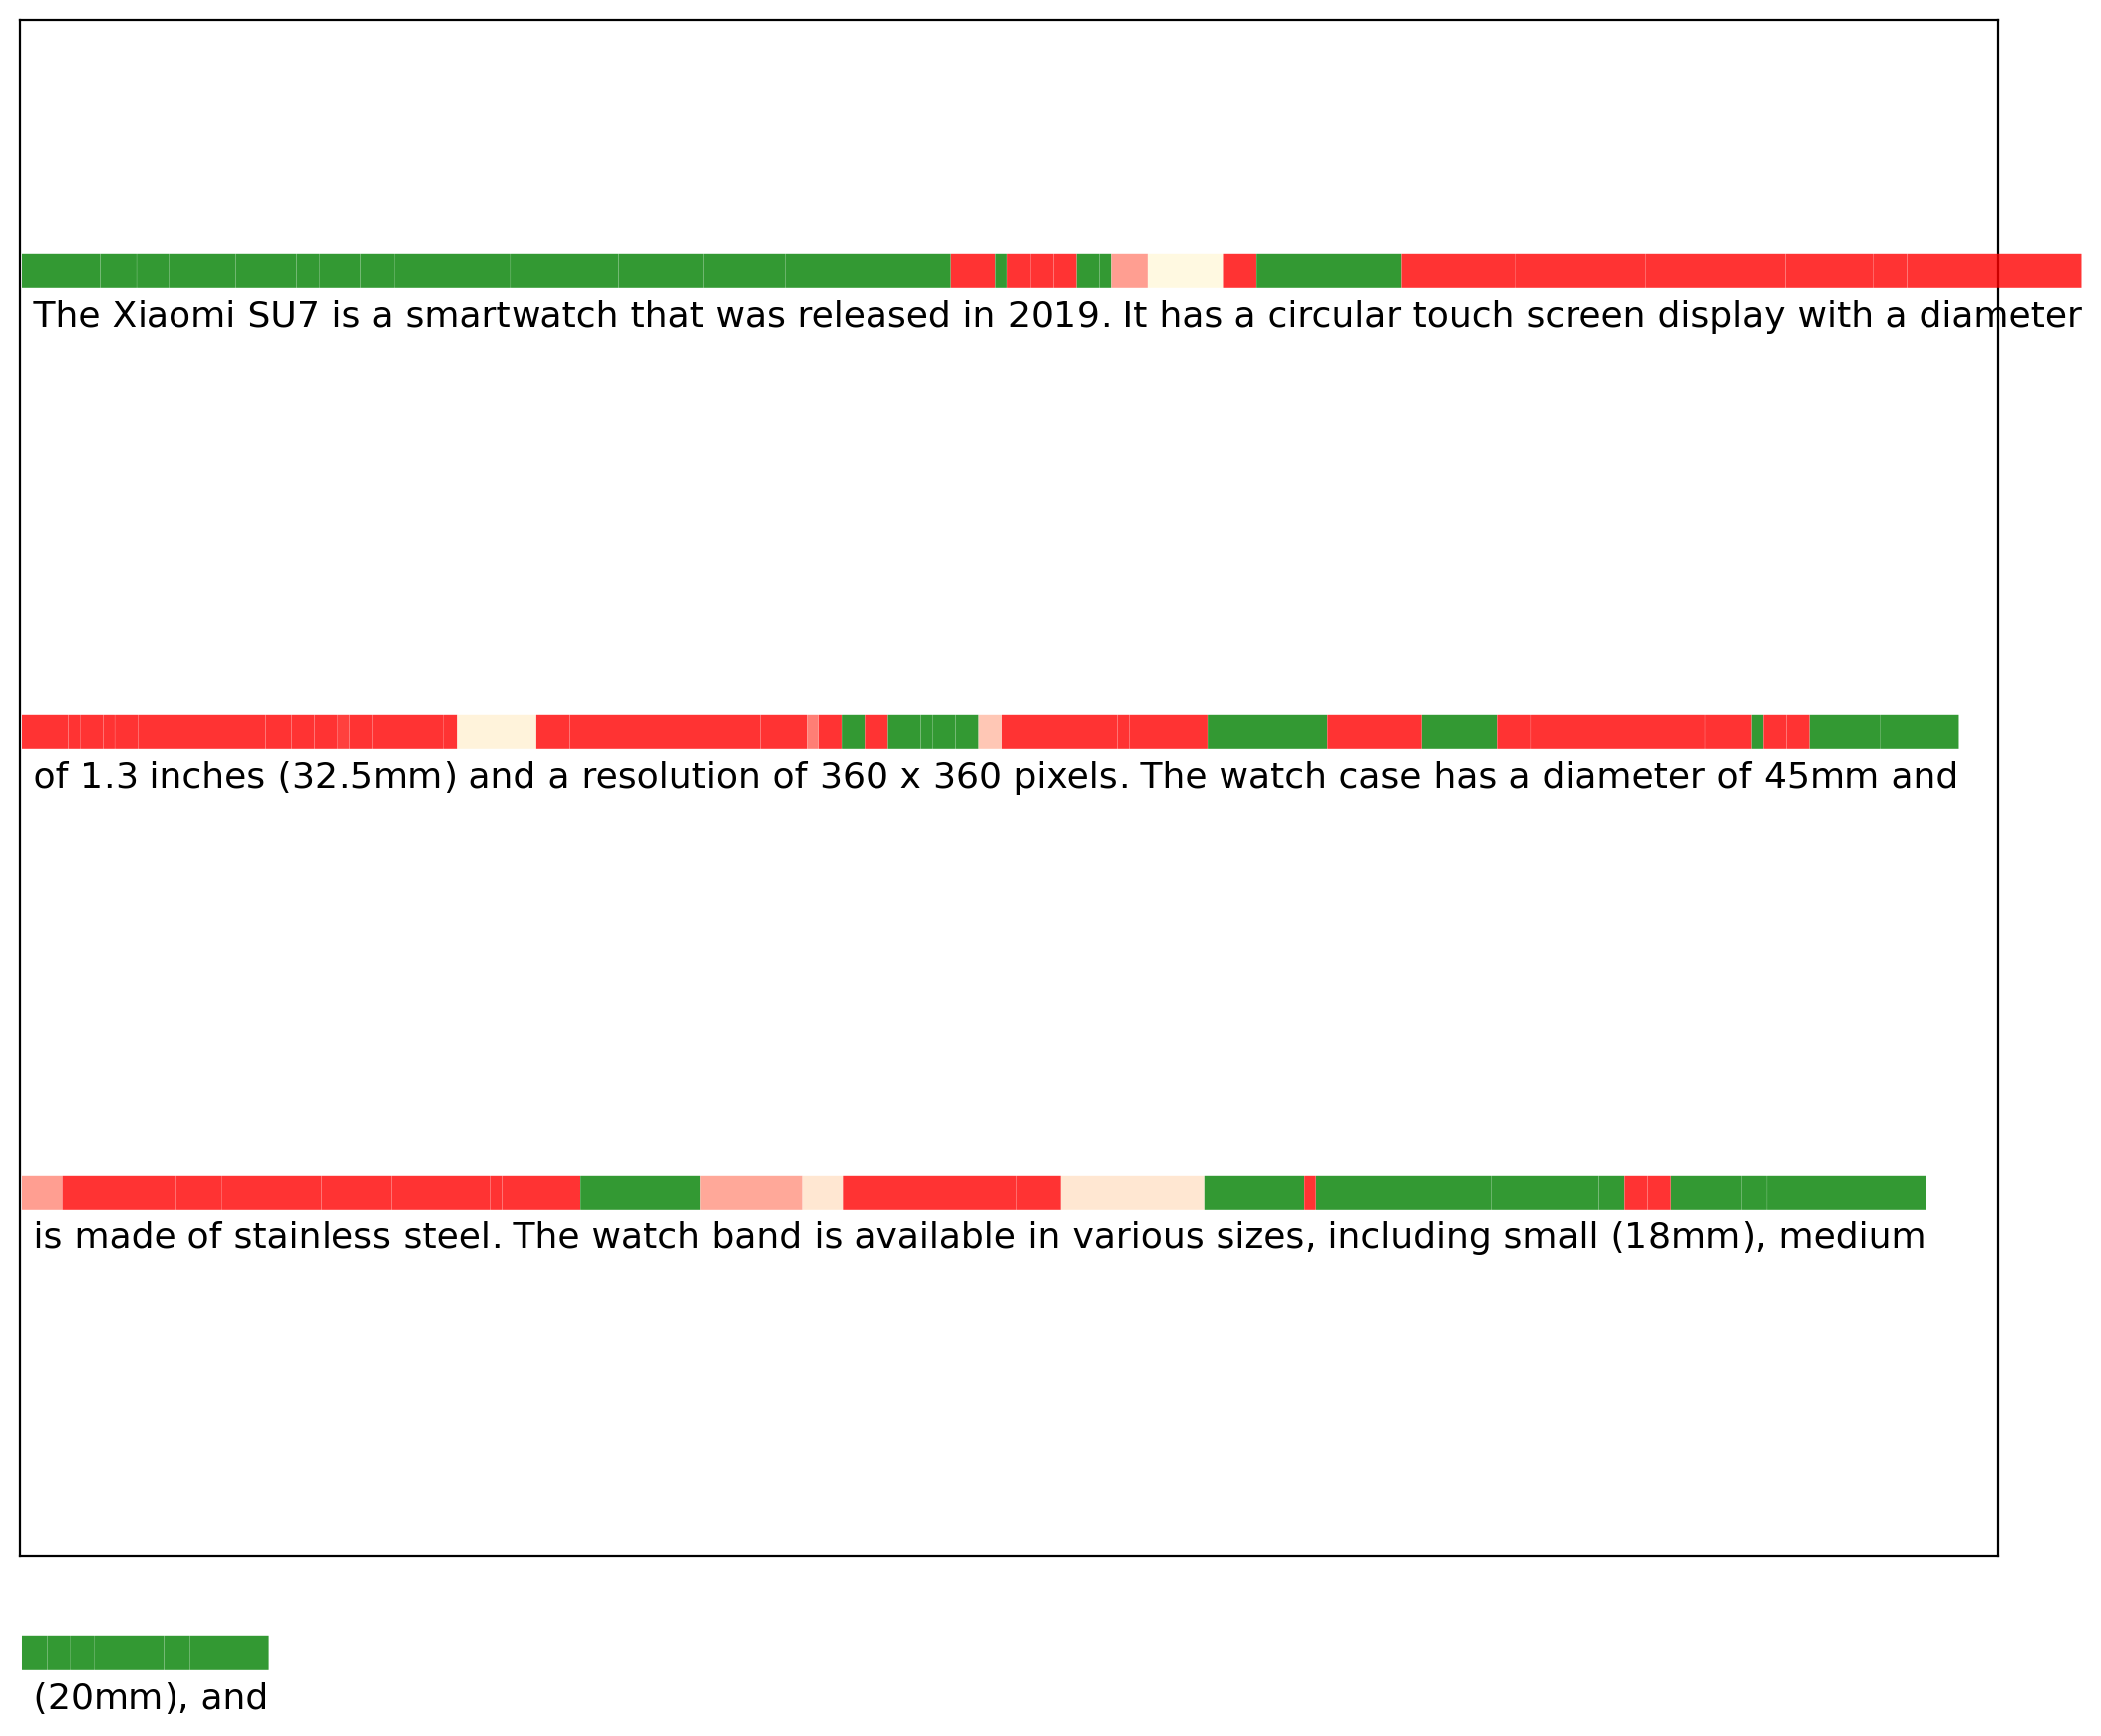

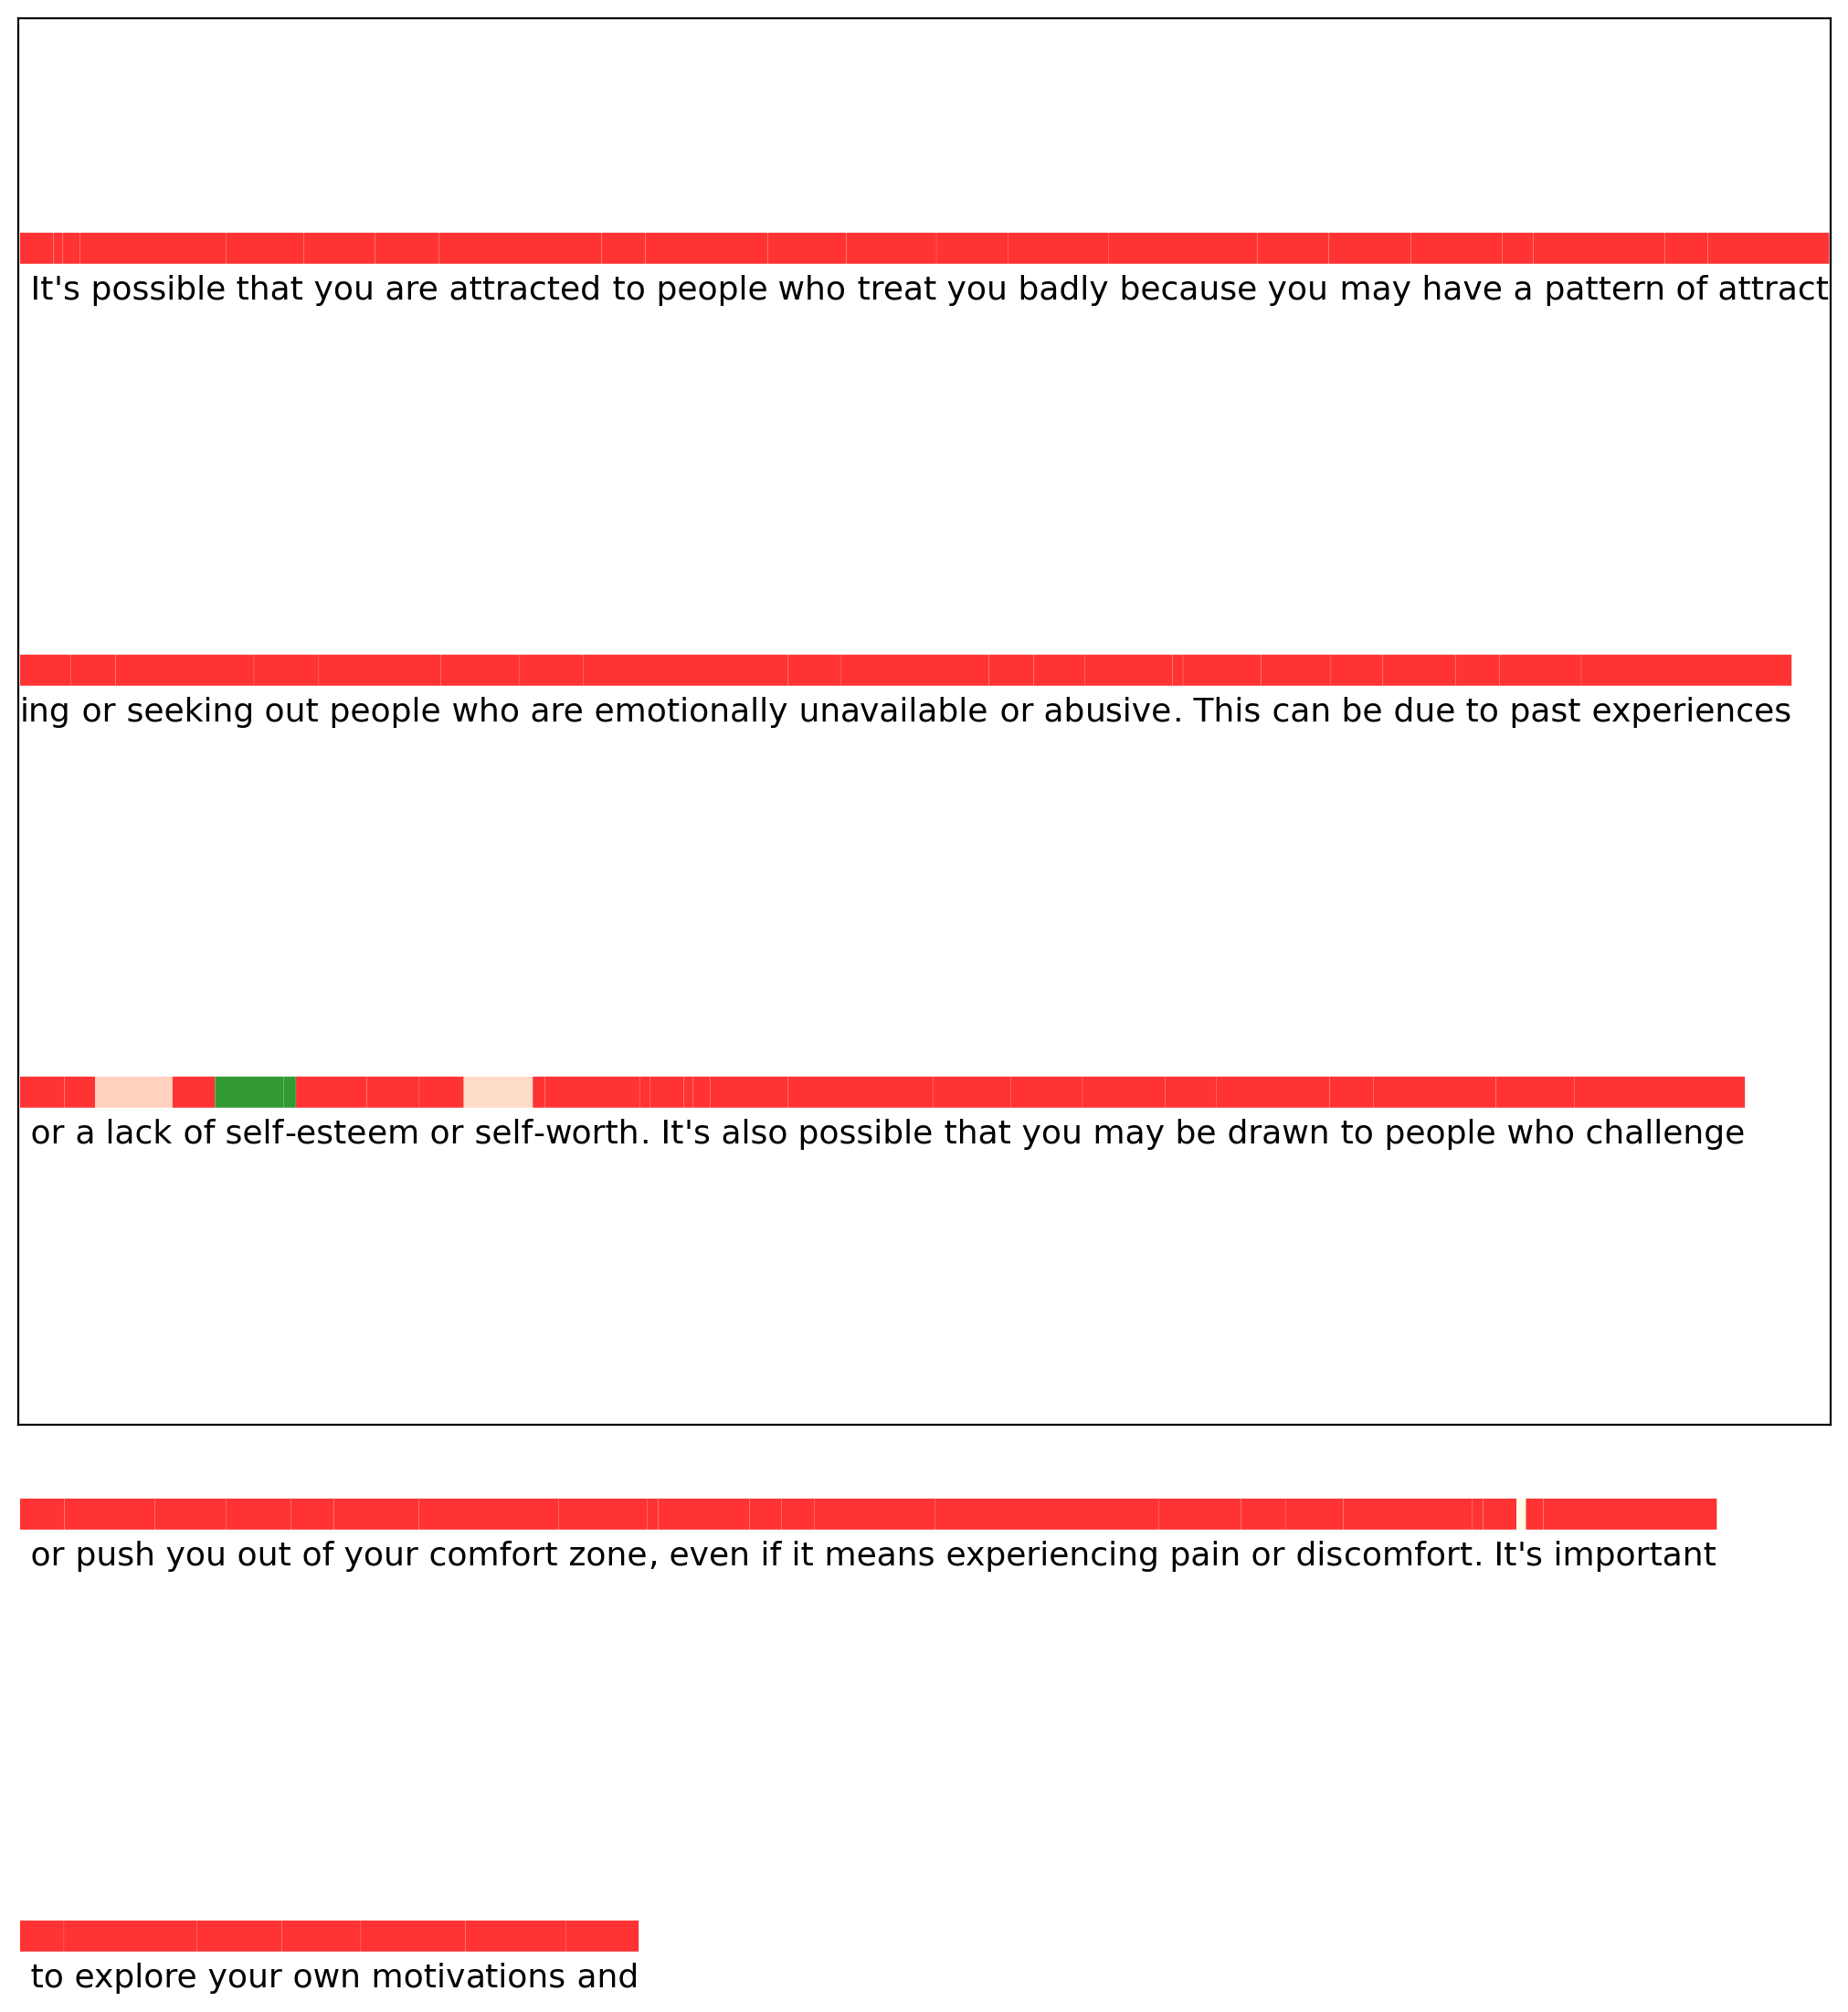

In [ ]:
# 以下是原project测试内容
layers = range(-10, -25, -1)
THRESHOLD = 0.0

test_input = [
    # Unknown Questions
    "What are the dimensions of the Xiaomi SU7?",
    # Unanswerable Questions
    "Why am I attracted to people who treat me badly yet can’t help myself from feeling attracted to them again and again despite how much they hurt me?",
]
plot_result_given_q(
    test_input=test_input,
    user_tag=user_tag,
    assistant_tag=assistant_tag,
    honesty_rep_reader=confidence_rep_reader,
    hidden_layers=hidden_layers,
    layers=layers,
    rep_reading_pipeline=rep_reading_pipeline,
    tokenizer=tokenizer,
    model=model,
    # chosen_idx=0,
    THRESHOLD=THRESHOLD,
)

In [ ]:
layer_id = list(range(-5, -18, -1))

block_name = "decoder_block"
control_method = "reading_vec"

rep_control_pipeline = pipeline(
    "rep-control",
    model=model,
    tokenizer=tokenizer,
    layers=layer_id,
    control_method=control_method)

Device set to use cuda:0


In [26]:
test_input = [
    "Which breed of dog is bigger, Japanese Terrier or Cane Corso?",
]

inputs = [
    f"{user_tag} {i} {assistant_tag}" for i in test_input
]

In [27]:
coeff = -1
max_new_tokens = 40

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(
        coeff * confidence_rep_reader.directions[layer] * confidence_rep_reader.direction_signs[layer]).to(
        model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens,
                                       do_sample=False, repetition_penalty=1.1)

for i, s, p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== - Confidence Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


===== No Control =====
 The Cane Corso is significantly larger than the Japanese Terrier. The Cane Corso is a breed of working dog that originated in Italy, and is known for its size, strength,
===== + Honesty Control =====
 The Cane Corso is generally considered to be a larger breed of dog than the Japanese Terrier.

